In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

In [2]:
path_to_data = os.pardir+"/../data/input_data/jan_models/"

geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=[20,2,200], 
                        path_o = path_to_data + "model1_orientations.csv",
                        path_i = path_to_data + "model1_surface_points.csv") 

Active grids: ['regular']


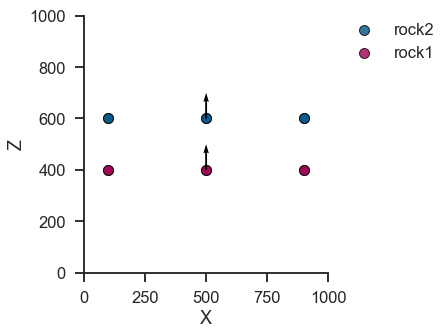

In [3]:
gp.plot.plot_data(geo_data)

In [4]:
gp.set_interpolation_data(geo_data, theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!


In [5]:
gp.compute_model(geo_data)


Lithology ids 
  [3.37754067 3.32054762 3.2684477  ... 0.7315523  0.67945238 0.62245933] 

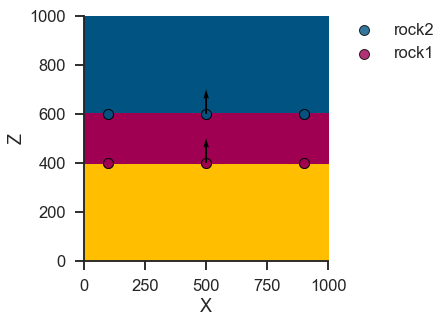

In [6]:
gp.plot.plot_section(geo_data, 1, show_data=True)

In [7]:
# Column 10 of the cross-section above
well = geo_data.solutions.lith_block.reshape(geo_data.grid.regular_grid.resolution)[10,1,:]
np.round(well)

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [8]:
# Computing the thickness in meters
thickness = (np.round(well) == 2).sum()*geo_data.grid.regular_grid.dz
thickness

210.0

In [15]:
g = geo_data.surface_points.df.groupby('series')
g.groups

{'Default series': Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype='int64'),
 'Basement': Int64Index([], dtype='int64')}

In [10]:
geo_data.modify_surface_points(g.groups[1], Z = 500)


,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,100,200,500,0.2501,0.3126,0.5001,rock2,Default series,1,1,1.000000e-08
1,500,200,500,0.5001,0.3126,0.5001,rock2,Default series,1,1,1.000000e-08
2,900,200,500,0.7501,0.3126,0.5001,rock2,Default series,1,1,1.000000e-08
3,100,800,500,0.2501,0.6876,0.5001,rock2,Default series,1,1,1.000000e-08
4,500,800,500,0.5001,0.6876,0.5001,rock2,Default series,1,1,1.000000e-08
5,900,800,500,0.7501,0.6876,0.5001,rock2,Default series,1,1,1.000000e-08
6,100,200,400,0.2501,0.3126,0.4376,rock1,Default series,2,1,1.000000e-08
7,500,200,400,0.5001,0.3126,0.4376,rock1,Default series,2,1,1.000000e-08
8,900,200,400,0.7501,0.3126,0.4376,rock1,Default series,2,1,1.000000e-08
9,100,800,400,0.2501,0.6876,0.4376,rock1,Default series,2,1,1.000000e-08


### Simple substraction likelihood. No GemPy involved:

In [87]:
with pm.Model() as model:
    r2 = pm.Normal('rock2', 600, 50)
    r1 = pm.Normal('rock1', 400, 50)
   
    mu = pm.Deterministic('mu', r2-r1)
    a = pm.Normal('y', mu=mu, sd=20, observed=[200])
    trace = pm.sample(10000,
                      step = pm.Metropolis(),
                      compute_convergence_checks=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [rock1]
>Metropolis: [rock2]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:04<00:00, 10383.38draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6ad335438>,
      dtype=object)

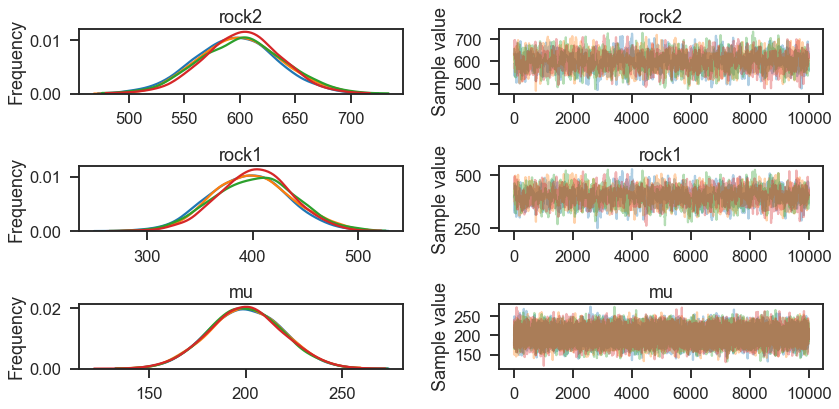

In [88]:
pm.traceplot(trace)

### Creating custom theano functions

Pymc3 only allows to use theano functions. GemPy has been written in theano - among other - for this particular reason. However, theano allows to create custom ops and hence call external functions. For this first notebook lets try to do so for a simple likelihood thickness:

In [96]:
def thickness(l2, l1):
    geo_data.modify_surface_points(g.groups[1], Z = l2)
    geo_data.modify_surface_points(g.groups[2], Z = l1)
    #gp.compute_model(geo_data)
    well = geo_data.solutions.lith_block.reshape(geo_data.grid.regular_grid.resolution)[10,1,:]
    thickness = (well == 2).sum()*geo_data.grid.regular_grid.dz
    return thickness
    
    

In [97]:
%%timeit
# Testing the most comvoluted way ever to make a substraction
thickness(800, 200)

38.8 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now we need to create a theano op that performs the function above:

In [93]:
import theano.tensor as tt

class MuFromTheta(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dscalar]

    def perform(self, node, inputs, outputs):
        theta, = inputs
        mu = thickness(theta[0], theta[1])
        outputs[0][0] = np.array(mu)

# The method allows for passing custom gradients too but we are not going to go down that road quite yet
    
#     def grad(self, inputs, g):
#         theta, = inputs
#         mu = self(theta)
#         thetamu = theta * mu
#         return [- g[0] * mu ** 2 / (1 + thetamu + tt.exp(-thetamu))]

In [94]:
tt_mu_from_theta = MuFromTheta()

In [95]:
ff = tt_mu_from_theta(theta)
mu.tag.test_value

array(200.)

In [60]:
%%timeit
with pm.Model() as model:
    r2 = pm.Normal('rock2', 600, 50)
    r1 = pm.Normal('rock1', 400, 50)
    theta = tt.as_tensor_variable([r2, r1])
    mu = pm.Deterministic('mu', tt_mu_from_theta(theta))
    a = pm.Normal('y', mu=mu, sd=20, observed=[200])

181 ms ± 5.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
with pm.Model() as model:
    r2 = pm.Normal('rock2', 600, 50)
    r1 = pm.Normal('rock1', 400, 50)
    theta = tt.as_tensor_variable([r2, r1])
    mu = pm.Deterministic('mu', tt_mu_from_theta(theta))
    a = pm.Normal('y', mu=mu, sd=20, observed=[200])
    trace = pm.sample(200, step = pm.Metropolis(), tune=50, cores=1, compute_convergence_checks=False)


Only 200 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [rock1]
>Metropolis: [rock2]
100%|██████████| 250/250 [01:25<00:00,  2.86it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe689c6e898>,
      dtype=object)

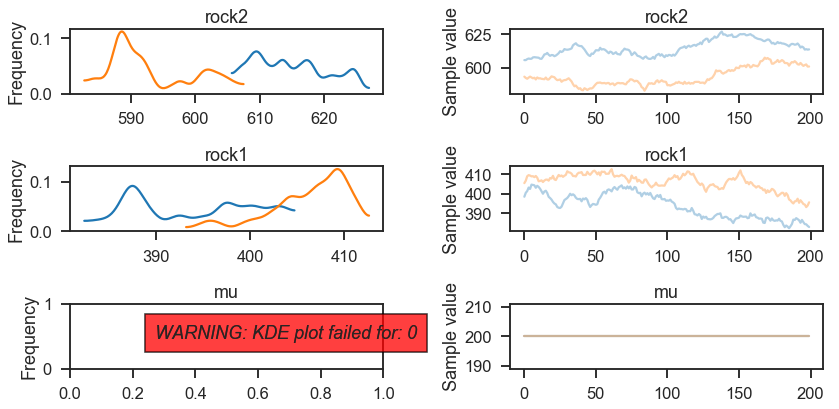

In [61]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe69b866cc0>,
      dtype=object)

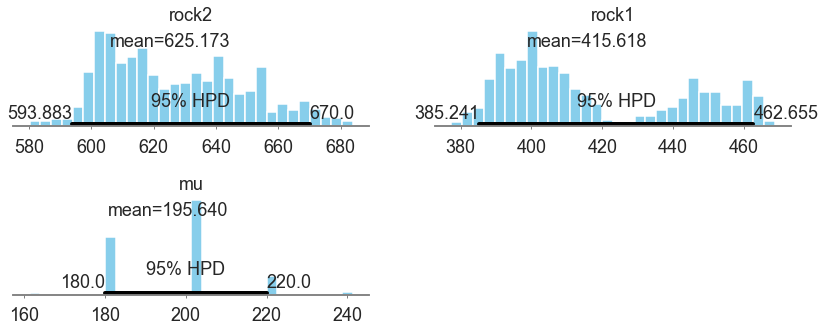

In [37]:
pm.plot_posterior(trace)

## Compiling gempy with PyMC3

In [68]:
import theano
theano.config.compute_test_value = 'ignore'

In [12]:
i = geo_data.interpolator.get_python_input_block()

In [69]:
geo_model_T = theano.OpFromGraph(geo_data.interpolator.theano_graph.input_parameters_loop,
                               geo_data.interpolator.theano_graph.compute_series(), inline=False,
                                 on_unused_input='warn',
                               name='geo_model')

In [17]:
rf = geo_data.rescaling.df.loc['values', 'rescaling factor']
centers = geo_data.rescaling.df.loc['values', 'centers']

In [18]:
# This is the new value for rock2
z_rock2 = 700

# We need to rescale
(z_rock2 - centers[2]) / rf + 0.5001

0.6251

In [19]:
# Now we need to change the input of the z of rock 2
i[4][g.groups[1], 2] = (z_rock2 - centers[2]) / rf + 0.5001
i[4]

array([[0.2501, 0.3126, 0.6251],
       [0.5001, 0.3126, 0.6251],
       [0.7501, 0.3126, 0.6251],
       [0.2501, 0.6876, 0.6251],
       [0.5001, 0.6876, 0.6251],
       [0.7501, 0.6876, 0.6251],
       [0.2501, 0.3126, 0.4376],
       [0.5001, 0.3126, 0.4376],
       [0.7501, 0.3126, 0.4376],
       [0.2501, 0.6876, 0.4376],
       [0.5001, 0.6876, 0.4376],
       [0.7501, 0.6876, 0.4376]])

In [98]:
import theano
import theano.tensor as tt
theano.config.compute_test_value = 'warn'
# We convert a python variable to theano.shared
input_sh = []
for ii in i:
    input_sh.append(theano.shared(ii))

with pm.Model() as model:
    r2 = pm.Normal('rock2', 600, 50)
    r1 = pm.Normal('rock1', 400, 50)
    val2 = (r2 - centers[2]) / rf + 0.5001
    val1 = (r1 - centers[2]) / rf + 0.5001

    input_sh[4] = tt.set_subtensor(input_sh[4][g.groups[1], 2], val2)
    input_sh[4] = tt.set_subtensor(input_sh[4][g.groups[2], 2], val1)
    
    # we have to take the sol 0
    geo = geo_model_T(*input_sh)[0][0][0:8000]
    well = geo.reshape(geo_data.grid.regular_grid.resolution)[10,1,:]
    thickness = pm.Deterministic('thickness', tt.sum(tt.eq(well, 2)) * geo_data.grid.regular_grid.dz)
    thickness.name = 'thickness'
    a = pm.Normal('y', mu=thickness, sd=20, observed=120)
    b = pm.Metropolis()
    trace = pm.sample(10000, chains=1,
                     step =b,
                     compute_convergence_checks=True, live_plot=False)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [rock1]
>Metropolis: [rock2]
100%|██████████| 10500/10500 [05:46<00:00, 30.35it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9cf1e92710>,
      dtype=object)

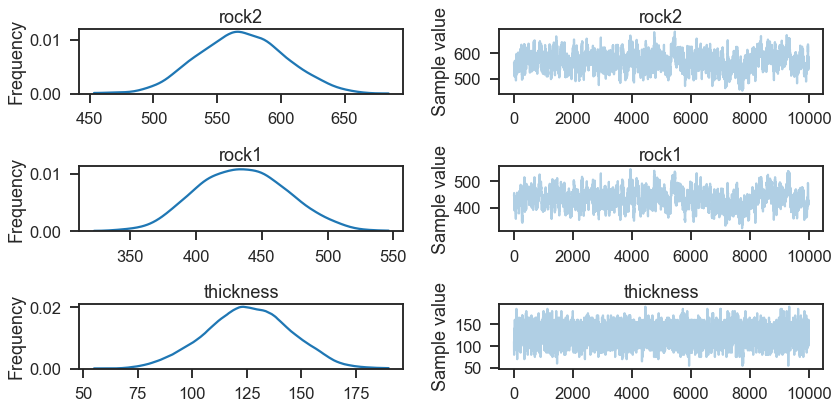

In [99]:
pm.traceplot(trace)

In [219]:
a

y